[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Segment Anything Model (SAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643)

Segment Anything Model (SAM): a new AI model from Meta AI that can "cut out" any object, in any image, with a single click. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training. This notebook is an extension of the [official notebook](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb) prepared by Meta AI.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-paper.png)

## Complementary Materials

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb) [![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-segment-anything-model-sam)

We recommend that you follow along in this notebook while reading the blog post on Segment Anything Model.

![segment anything model blogpost](https://media.roboflow.com/notebooks/examples/segment-anything-model-blogpost.png)

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- Install Segment Anything Model (SAM)
- Download Example Data
- Load Model
- Automated Mask Generation
- Generate Segmentation with Bounding Box
- Segment Anything in Roboflow Universe Dataset

## Let's begin!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Jun 20 08:50:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [3]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [4]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.0 MB/s eta 0:00:00


### Download SAM weights

In [5]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [8]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [30]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [31]:
import os
FOLDER_NAME = '1742387607589325358-1742387607589975615'
IMAGE_PATH = os.path.join(HOME, "data", 'vis.png')

### Generate masks with SAM

In [32]:
import cv2
import supervision as sv

image_gray = cv2.imread(IMAGE_PATH)
image_gray = image_gray[:,:image_gray.shape[1]//2,:]

In [33]:
image_gray.shape

(480, 640, 3)

In [34]:
sam_result = mask_generator.generate(image_gray)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [35]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

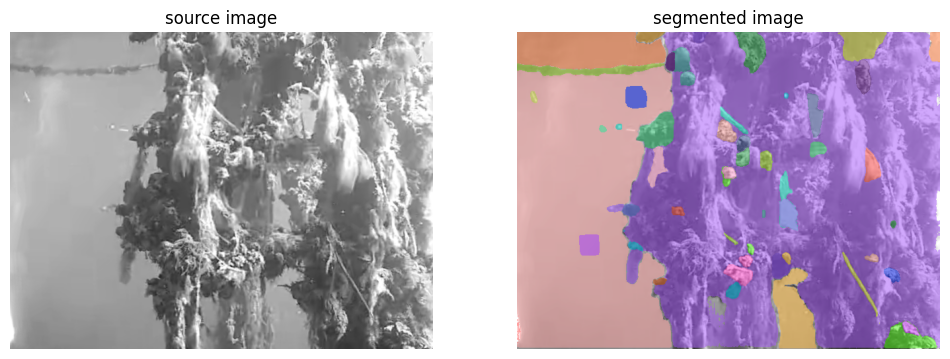

In [36]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_gray.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_gray, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

In [47]:
masks[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [89]:
is_background = [0,1,1,1,1,0,0,
                 0,0,0,1,0,0,1,
                 1,0,0,0,0,0,0]

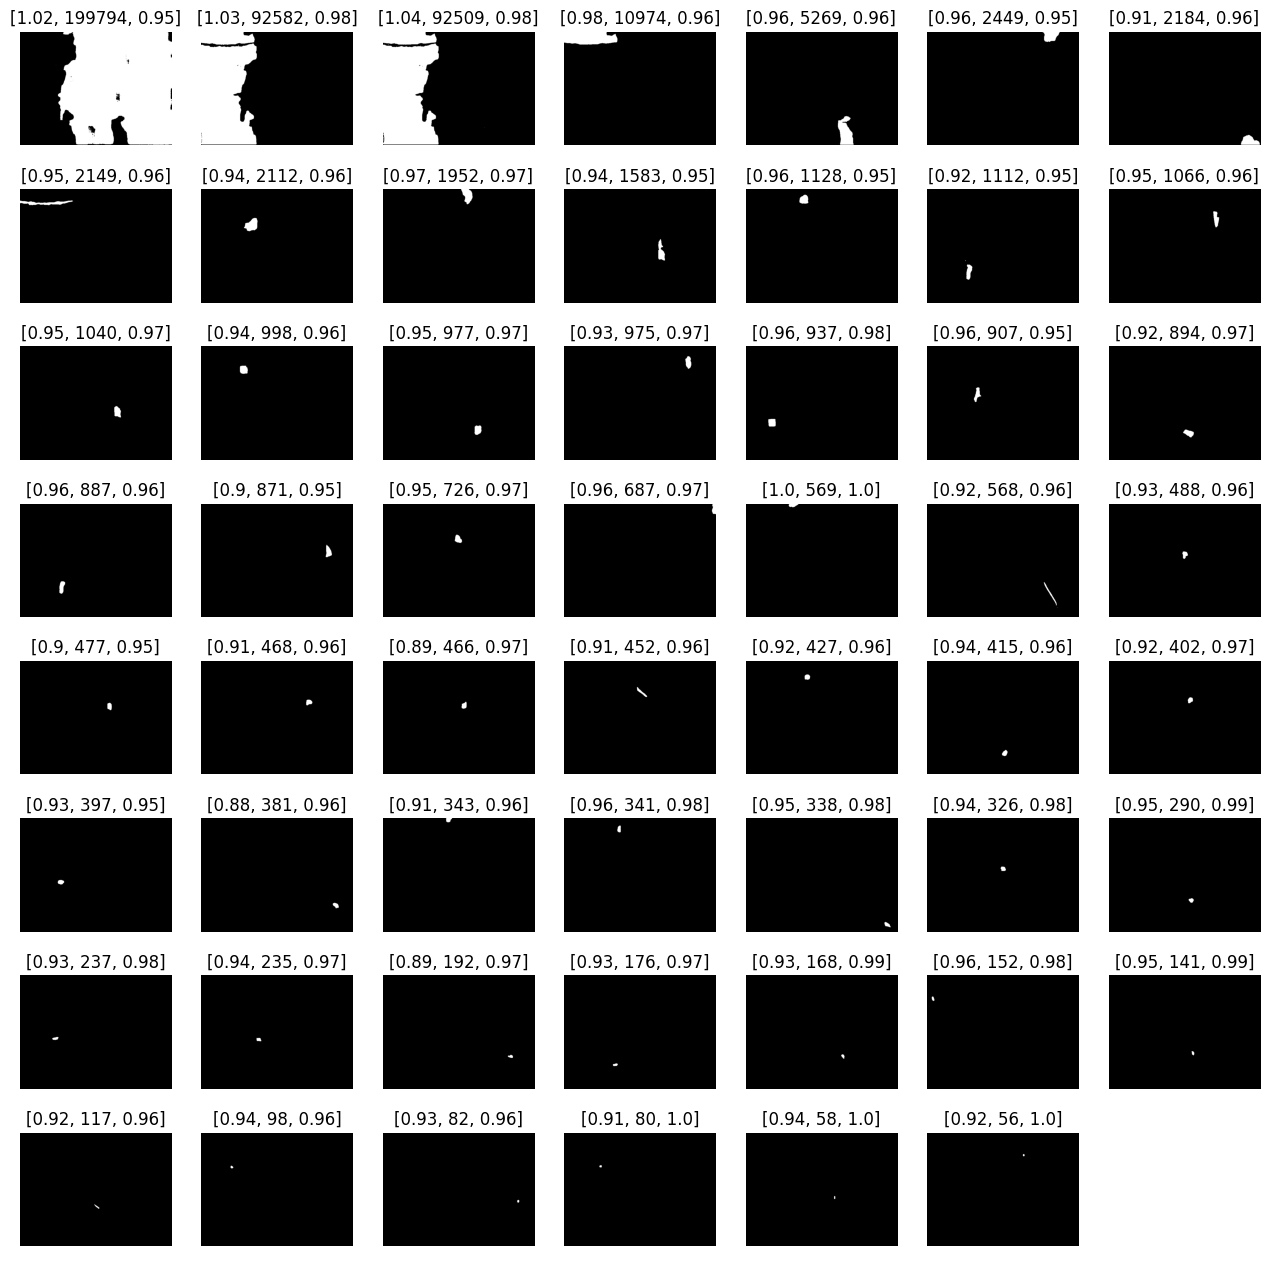

In [46]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

titles = [
    [round(mask['predicted_iou'],2),round(mask['area'],2),round(mask['stability_score'],2)]
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8 + 1)),
    size=(16, 16),
    titles=titles
)

# Examine bounding box edges and etc

In [88]:
# prompt: perform image processing on the masks to see what how they score in terms of number of edges, gradient direction etc

import numpy as np

def analyze_mask(mask):
    """
    Analyzes a binary mask to extract image processing features.

    Args:
        mask (np.ndarray): A boolean or uint8 mask with True/1 for the object.

    Returns:
        dict: A dictionary containing analysis results:
              - 'edges': Number of detected edges in the mask.
              - 'gradient_magnitude': Average gradient magnitude within the mask.
              - 'gradient_direction': Histogram of gradient directions within the mask.
              - 'area': Area of the mask.
              - 'perimeter': Perimeter of the mask.
    """
    # Ensure mask is in uint8 format
    mask_uint8 = mask.astype(np.uint8) * 255

    # Calculate area
    area = np.sum(mask)

    # Calculate perimeter using contours
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perimeter = 0
    for contour in contours:
        perimeter += cv2.arcLength(contour, True)

    # Edge detection using Canny
    edges = cv2.Canny(mask_uint8, 100, 200)
    num_edges = np.sum(edges > 0)

    # Gradient analysis
    sobelx = cv2.Sobel(mask_uint8, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(mask_uint8, cv2.CV_64F, 0, 1, ksize=5)

    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    gradient_direction = np.arctan2(sobely, sobelx) * (180 / np.pi) # in degrees

    # Filter out gradients outside the mask
    gradient_magnitude_masked = gradient_magnitude[mask]
    gradient_direction_masked = gradient_direction[mask]

    avg_gradient_magnitude = np.mean(gradient_magnitude_masked) if gradient_magnitude_masked.size > 0 else 0

    # Create a histogram of gradient directions within the mask
    hist, _ = np.histogram(gradient_direction_masked, bins=36, range=(-180, 180))
    gradient_direction_histogram = hist.tolist()

    # Calculate mean intensity
    mean_intensity = np.mean(mask_uint8)



    return {
        'area': area,
        'perimeter': perimeter,
        'edges': num_edges,
        'gradient_magnitude': avg_gradient_magnitude,
        'gradient_direction_histogram': gradient_direction_histogram,
        'mean_intensity': mean_intensity
    }

# Analyze each mask in the results
masks_to_analyze = [
    mask for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True) if mask['area'] > 1000
]

mask_analysis_results = []
for mask_info in masks_to_analyze:
    mask = mask_info['segmentation']
    analysis = analyze_mask(mask)
    mask_analysis_results.append(analysis)

# Print or process the analysis results
for i, analysis in enumerate(mask_analysis_results):
    print(f"Analysis for Mask {i+1}:")
    print(f"  Area: {analysis['area']}")
    print(f"  Perimeter: {analysis['perimeter']:.2f}")
    print(f"  Number of Edges: {analysis['edges']}")
    print(f"  Average Gradient Magnitude: {analysis['gradient_magnitude']:.2f}")
    print(f"  Mean Intensity: {analysis['mean_intensity']:.2f}")
    print(f"  Edge/area Ratio: {analysis['edges'] / analysis['area']:.4f}")
    # print(f"  Gradient Direction Histogram: {analysis['gradient_direction_histogram']}") # Uncomment to see the histogram
    print("-" * 20)

Analysis for Mask 1:
  Area: 199794
  Perimeter: 2498.49
  Number of Edges: 2404
  Average Gradient Magnitude: 179.15
  Mean Intensity: 165.84
  Edge/area Ratio: 0.0120
--------------------
Analysis for Mask 2:
  Area: 92582
  Perimeter: 2183.52
  Number of Edges: 1719
  Average Gradient Magnitude: 300.68
  Mean Intensity: 76.85
  Edge/area Ratio: 0.0186
--------------------
Analysis for Mask 3:
  Area: 92509
  Perimeter: 2220.00
  Number of Edges: 1752
  Average Gradient Magnitude: 304.43
  Mean Intensity: 76.79
  Edge/area Ratio: 0.0189
--------------------
Analysis for Mask 4:
  Area: 10974
  Perimeter: 562.99
  Number of Edges: 476
  Average Gradient Magnitude: 655.30
  Mean Intensity: 9.11
  Edge/area Ratio: 0.0434
--------------------
Analysis for Mask 5:
  Area: 5269
  Perimeter: 399.76
  Number of Edges: 389
  Average Gradient Magnitude: 1140.80
  Mean Intensity: 4.37
  Edge/area Ratio: 0.0738
--------------------
Analysis for Mask 6:
  Area: 2449
  Perimeter: 216.12
  Number o

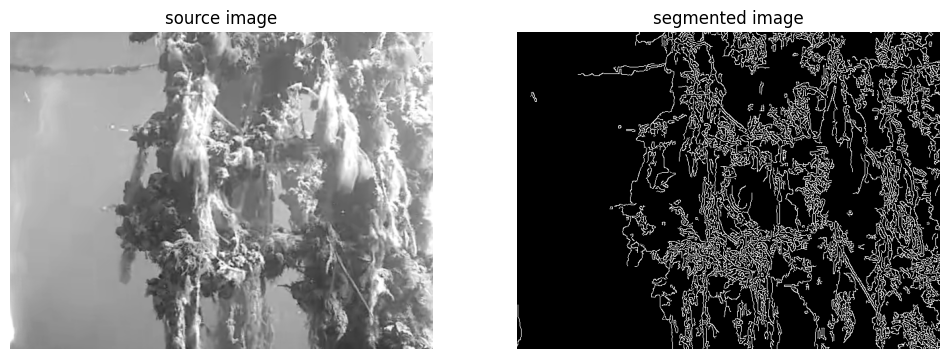

In [69]:
img = image_gray.copy()
t_lower = 50
t_upper = 150
edge = cv2.Canny(img, t_lower, t_upper)


sv.plot_images_grid(
    images=[image_gray,edge],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)


In [80]:
np.sum((edge > 0) & masks_to_analyze[0]['segmentation'])

np.int64(35830)

In [78]:
np.sum((edge > 0) & masks_to_analyze[1]['segmentation'])

np.int64(285)

In [81]:
np.sum((edge > 0) & masks_to_analyze[2]['segmentation'])

np.int64(275)

In [82]:
np.sum((edge > 0) & masks_to_analyze[3]['segmentation'])

np.int64(13)

In [83]:
np.sum((edge > 0) & masks_to_analyze[4]['segmentation'])

np.int64(135)

In [84]:
np.sum((edge > 0) & masks_to_analyze[5]['segmentation'])

np.int64(89)

In [91]:
for i in range(len(masks_to_analyze)):
    mask_info = masks_to_analyze[i]
    mask = mask_info['segmentation']
    edges = np.sum((edge > 0) & mask)
    edge_ratio = edges / mask_info['area']

    print(f"mask {i} (background={is_background[i]}): Number of edges in mask {edges} edge/area={edge_ratio}")

mask 0 (background=0): Number of edges in mask 35830 edge/area=0.1793347147561989
mask 1 (background=1): Number of edges in mask 285 edge/area=0.003078352163487503
mask 2 (background=1): Number of edges in mask 275 edge/area=0.0029726837388794605
mask 3 (background=1): Number of edges in mask 13 edge/area=0.0011846181884454165
mask 4 (background=1): Number of edges in mask 135 edge/area=0.02562156006832416
mask 5 (background=0): Number of edges in mask 89 edge/area=0.03634136382196815
mask 6 (background=0): Number of edges in mask 579 edge/area=0.2651098901098901
mask 7 (background=0): Number of edges in mask 234 edge/area=0.10888785481619358
mask 8 (background=0): Number of edges in mask 401 edge/area=0.18986742424242425
mask 9 (background=0): Number of edges in mask 646 edge/area=0.33094262295081966
mask 10 (background=1): Number of edges in mask 214 edge/area=0.1351863550221099
mask 11 (background=0): Number of edges in mask 138 edge/area=0.12234042553191489
mask 12 (background=0): 

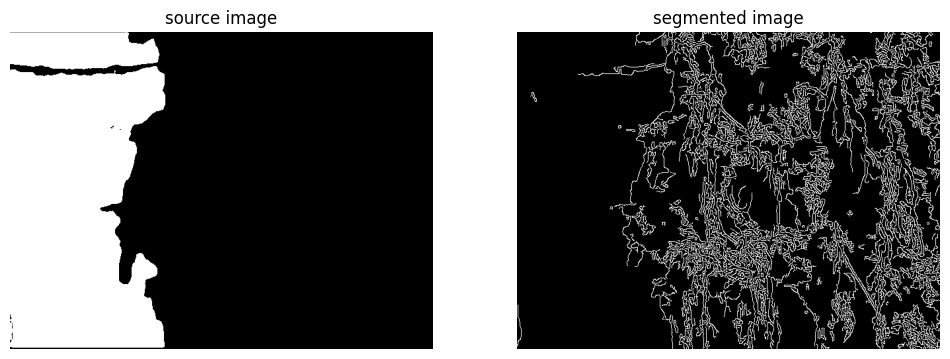

In [79]:
sv.plot_images_grid(
    images=[masks_to_analyze[1]['segmentation'],edge],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [63]:


widget = BBoxWidget()
widget.image = edge
widget

TraitError: The 'image' trait of a BBoxWidget instance expected a unicode string, not the ndarray array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0, 255],
       [  0,   0,   0, ...,   0, 255, 255]], dtype=uint8).

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 69, 'y': 246, 'width': 555, 'height': 684, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

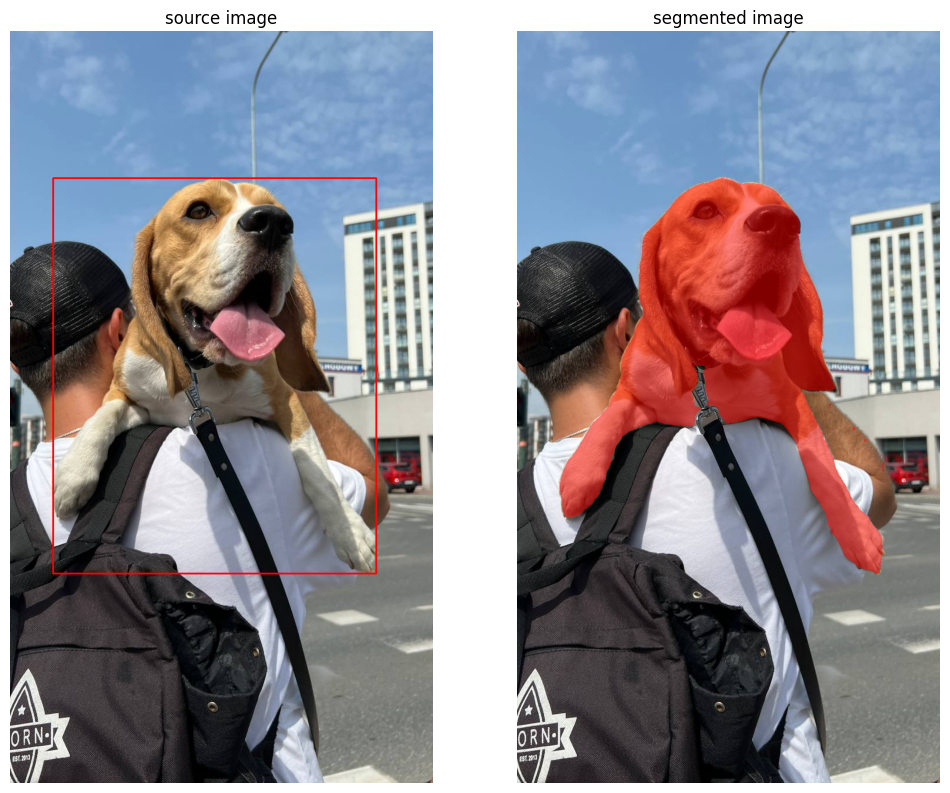

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

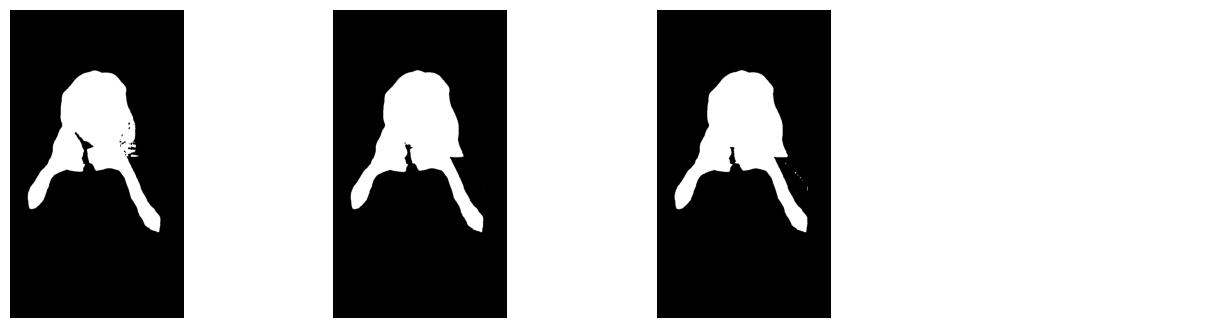

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

## Segment Anything in Roboflow Universe Dataset

### Utils Supporting Dataset Processing

A couple of helper functions that, unfortunately, we have to write ourselves to facilitate the processing of COCO annotations.

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

### Download Dataset from Roboflow

In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("hashira-fhxpj").project("mri-brain-tumor")
dataset = project.version(1).download("coco")

In [ ]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [ ]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [ ]:
CLASSES

['YES-TUMOR']

### Single Image Bounding Box to Mask

In [ ]:
# set random seed to allow easy reproduction of the experiment

import random
random.seed(10)

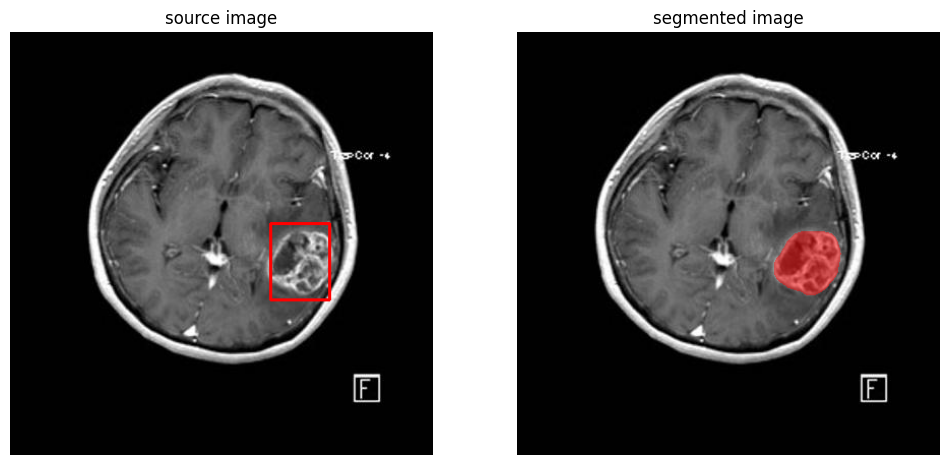

In [ ]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth)

# run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.